# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 29.11.2023

Мягий дедлайн: 23:59 12.12.2023

Жестокий дедлайн: 23:59 14.12.2023

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/56884/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__ 10 + 1 бонус

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification


datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

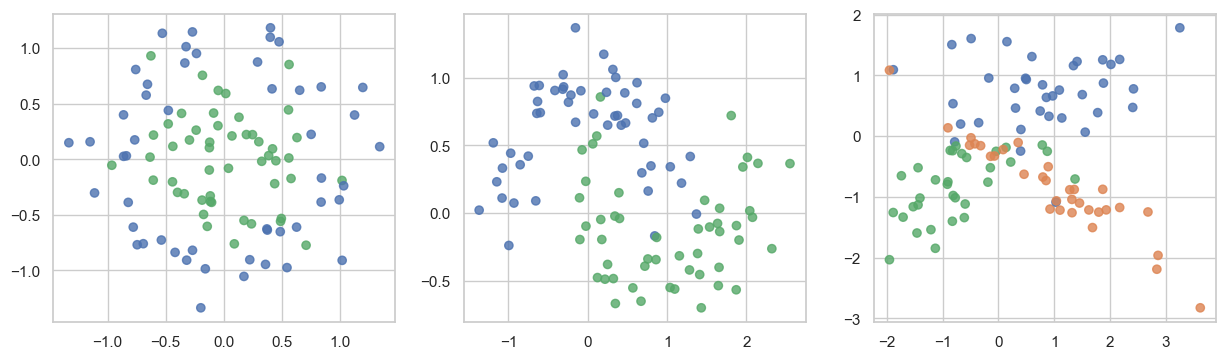

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y, ax=None):
    
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if ax:
        cs = ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
    else:
        cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    if ax:
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                    edgecolors=np.array(palette)[y], linewidths=2)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                    edgecolors=np.array(palette)[y], linewidths=2)

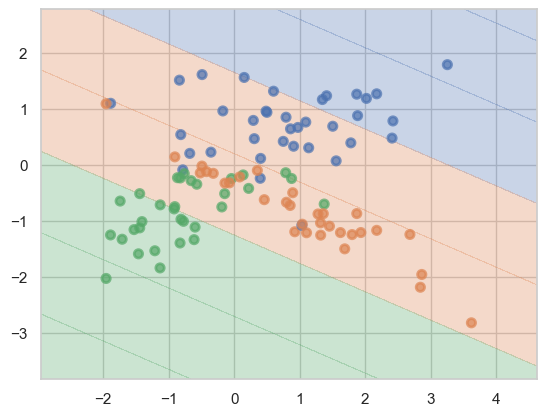

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression


X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

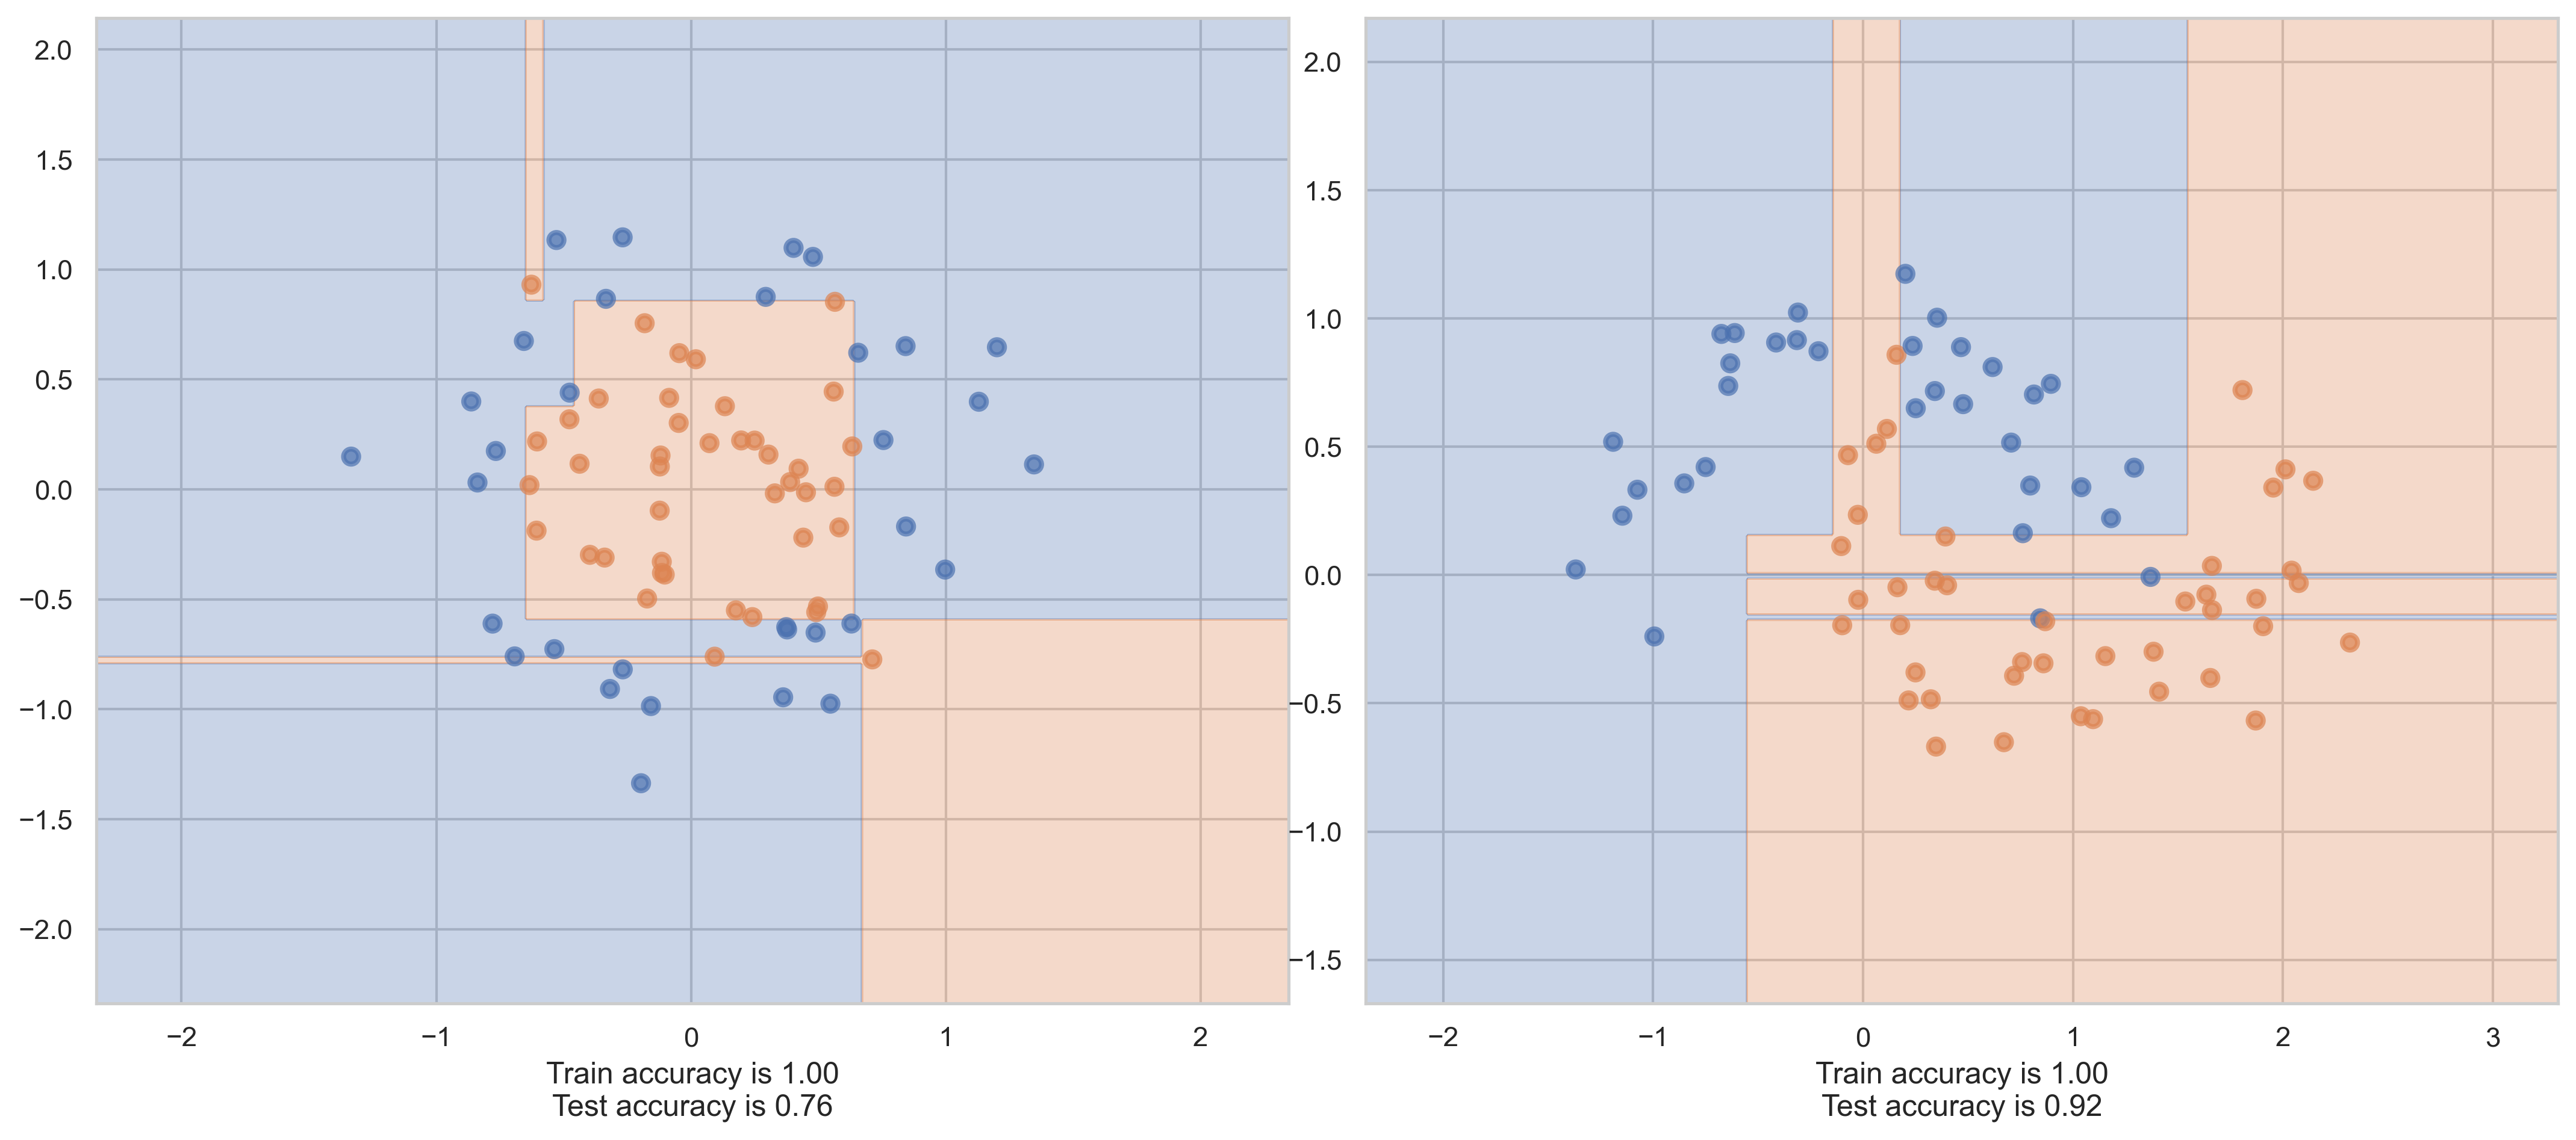

In [7]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(15, 7))

for i, dataset in enumerate(datasets[0:2]):
    X, y = dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    plot_surface(clf, X_train, y_train, axes[i])

    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)

    axes[i].set_xlabel(f'Train accuracy is {acc_train:.2f}\nTest accuracy is {acc_test:.2f}')
    

__Ответ:__ По графику и значениям accuracy видно что деревья здорово переобучились, особенно дерево на датастете с circles, потому что для одного объекта справа снизу выделяется здоровый кусок области

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [8]:
max_depthes = [1, 5, 12]
min_samples_leafs = [12, 5, 1]

fig, axes = plt.subplots(len(max_depthes), len(min_samples_leafs), dpi=300, figsize=(30, 30))

for i, max_depth in enumerate(max_depthes):
    for j, min_samples_leaf in enumerate(min_samples_leafs):
        X, y = datasets[0]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        clf = DecisionTreeClassifier(random_state=42, 
                                     max_depth=max_depth, 
                                     min_samples_leaf=min_samples_leaf)
        clf.fit(X_train, y_train)

        plot_surface(clf, X_train, y_train, axes[i, j])

        acc_train = clf.score(X_train, y_train)
        acc_test = clf.score(X_test, y_test)

        axes[i, j].set_xlabel(f'Train accuracy is {acc_train:.2f}\nTest accuracy is {acc_test:.2f}', 
                              fontsize=20)
        axes[i, j].set_title(f'Max depth is {max_depth}\nMin samples leaf is {min_samples_leaf}', 
                             fontsize=30)
        
plt.show()

In [9]:
max_depthes = [1, 5, 12]
min_samples_leafs = [12, 5, 1]

fig, axes = plt.subplots(len(max_depthes), len(min_samples_leafs), dpi=300, figsize=(30, 30))

for i, max_depth in enumerate(max_depthes):
    for j, min_samples_leaf in enumerate(min_samples_leafs):
        X, y = datasets[1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        clf = DecisionTreeClassifier(random_state=42, 
                                     max_depth=max_depth, 
                                     min_samples_leaf=min_samples_leaf)
        clf.fit(X_train, y_train)

        plot_surface(clf, X_train, y_train, axes[i, j])

        acc_train = clf.score(X_train, y_train)
        acc_test = clf.score(X_test, y_test)

        axes[i, j].set_xlabel(f'Train accuracy is {acc_train:.2f}\nTest accuracy is {acc_test:.2f}', 
                              fontsize=20)
        axes[i, j].set_title(f'Max depth is {max_depth}\nMin samples leaf is {min_samples_leaf}', 
                             fontsize=30)
        
plt.show()

__Ответ:__ Изменение для разных датасетов практически идентичны, в обоих случаях нужен баланс, дерево не должно быть как и слишком простым так и слишком сложным, в первом случае происходит недообучение, а во втором переобучение

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [10]:
data = pd.read_csv('students.csv')

X = data.drop(columns=['UNS'])
y = data['UNS']

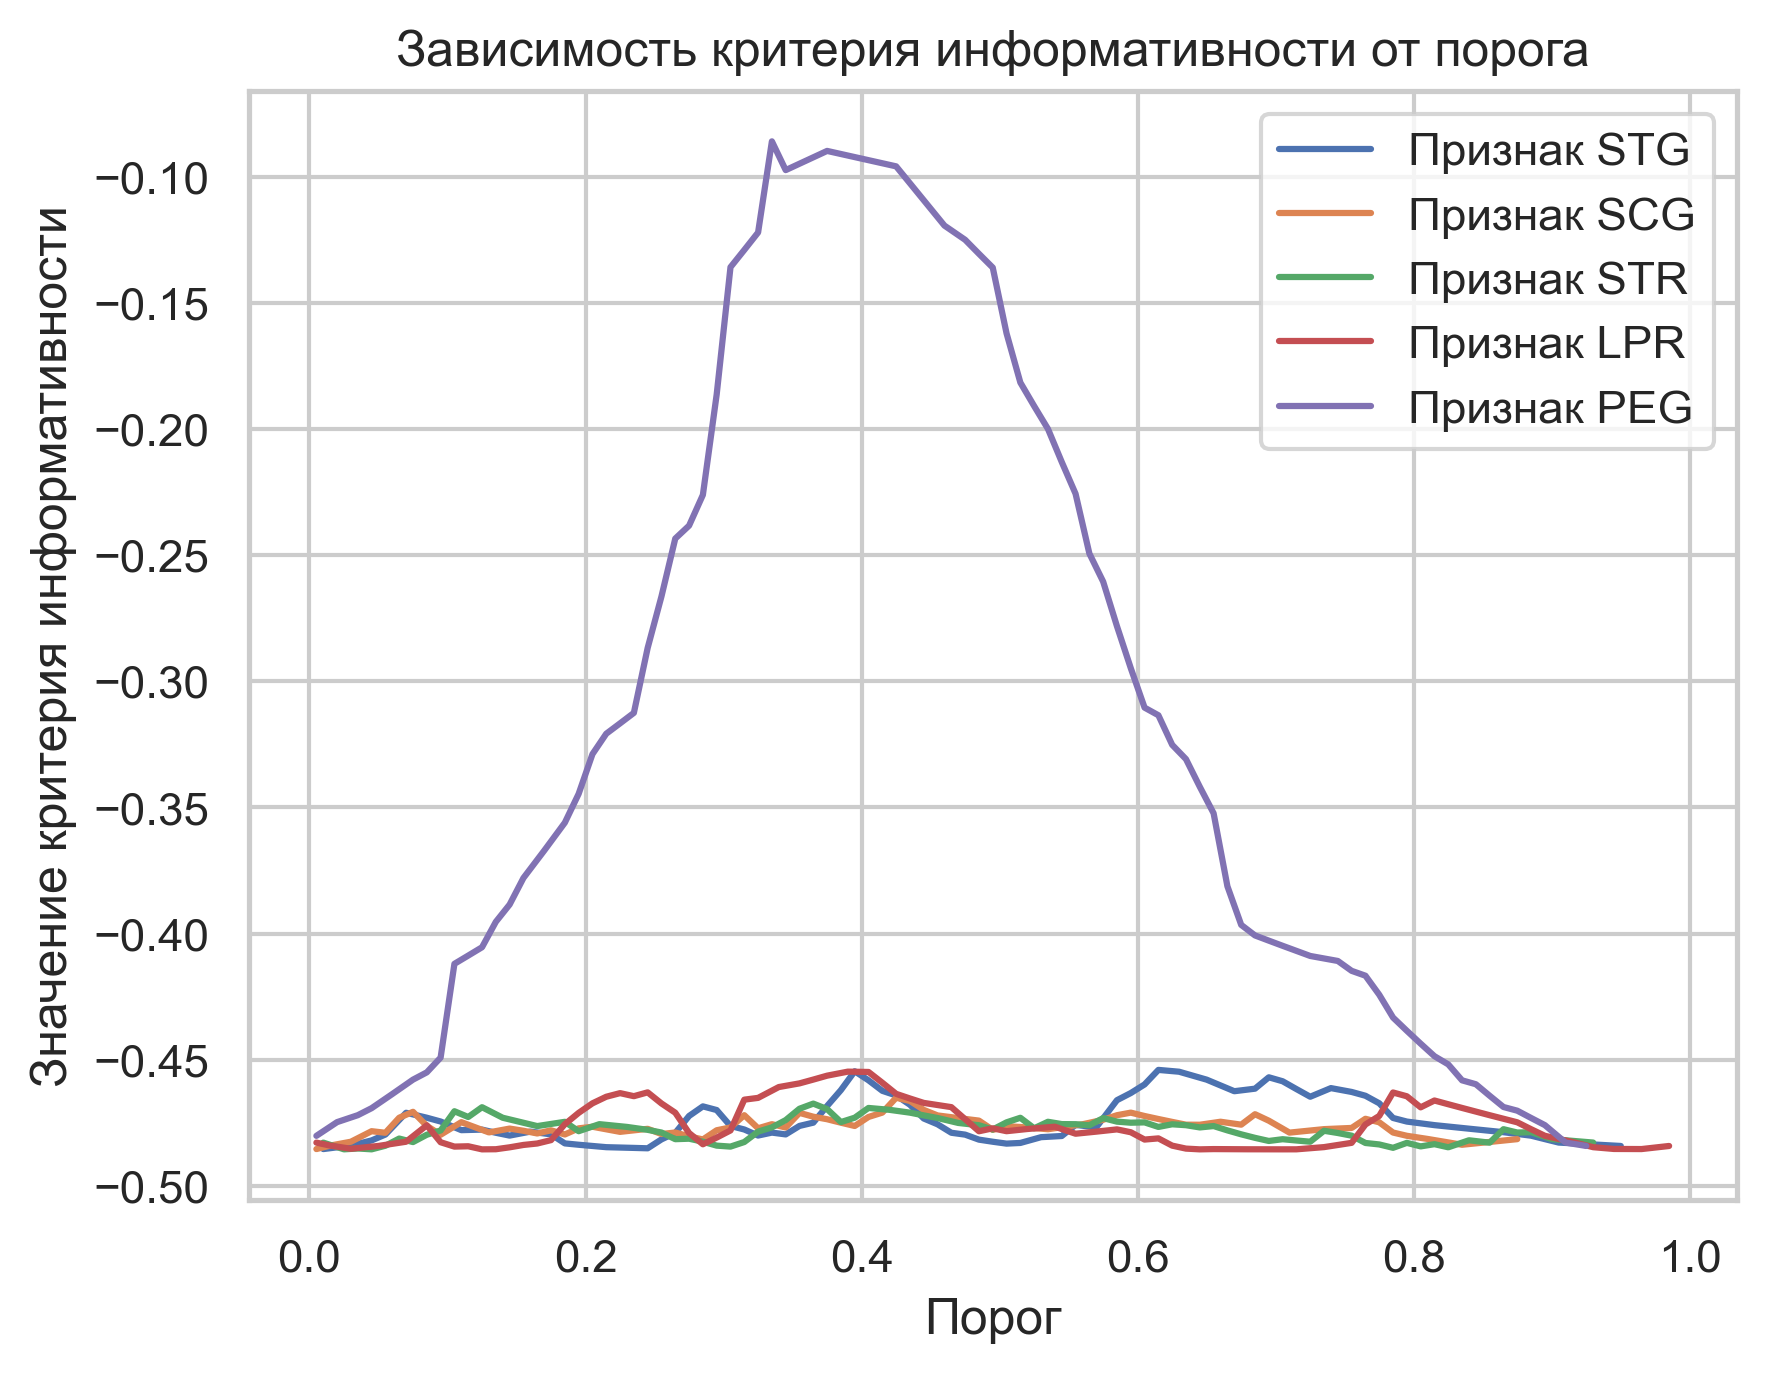

In [11]:
%autoreload 2
from hw5code import find_best_split


fig, ax = plt.subplots(dpi = 300)

ax.plot(find_best_split(X.STG.values, y.values)[0], 
        find_best_split(X.STG.values, y.values)[1], 
        label='Признак STG')

ax.plot(find_best_split(X.SCG.values, y.values)[0], 
        find_best_split(X.SCG.values, y.values)[1], 
        label='Признак SCG')

ax.plot(find_best_split(X.STR.values, y.values)[0], 
        find_best_split(X.STR.values, y.values)[1], 
        label='Признак STR')

ax.plot(find_best_split(X.LPR.values, y.values)[0], 
        find_best_split(X.LPR.values, y.values)[1], 
        label='Признак LPR')

ax.plot(find_best_split(X.PEG.values, y.values)[0], 
        find_best_split(X.PEG.values, y.values)[1], 
        label='Признак PEG')

ax.set_ylabel('Значение критерия информативности')
ax.set_xlabel('Порог')
ax.set_title('Зависимость критерия информативности от порога')
ax.legend()

plt.show()

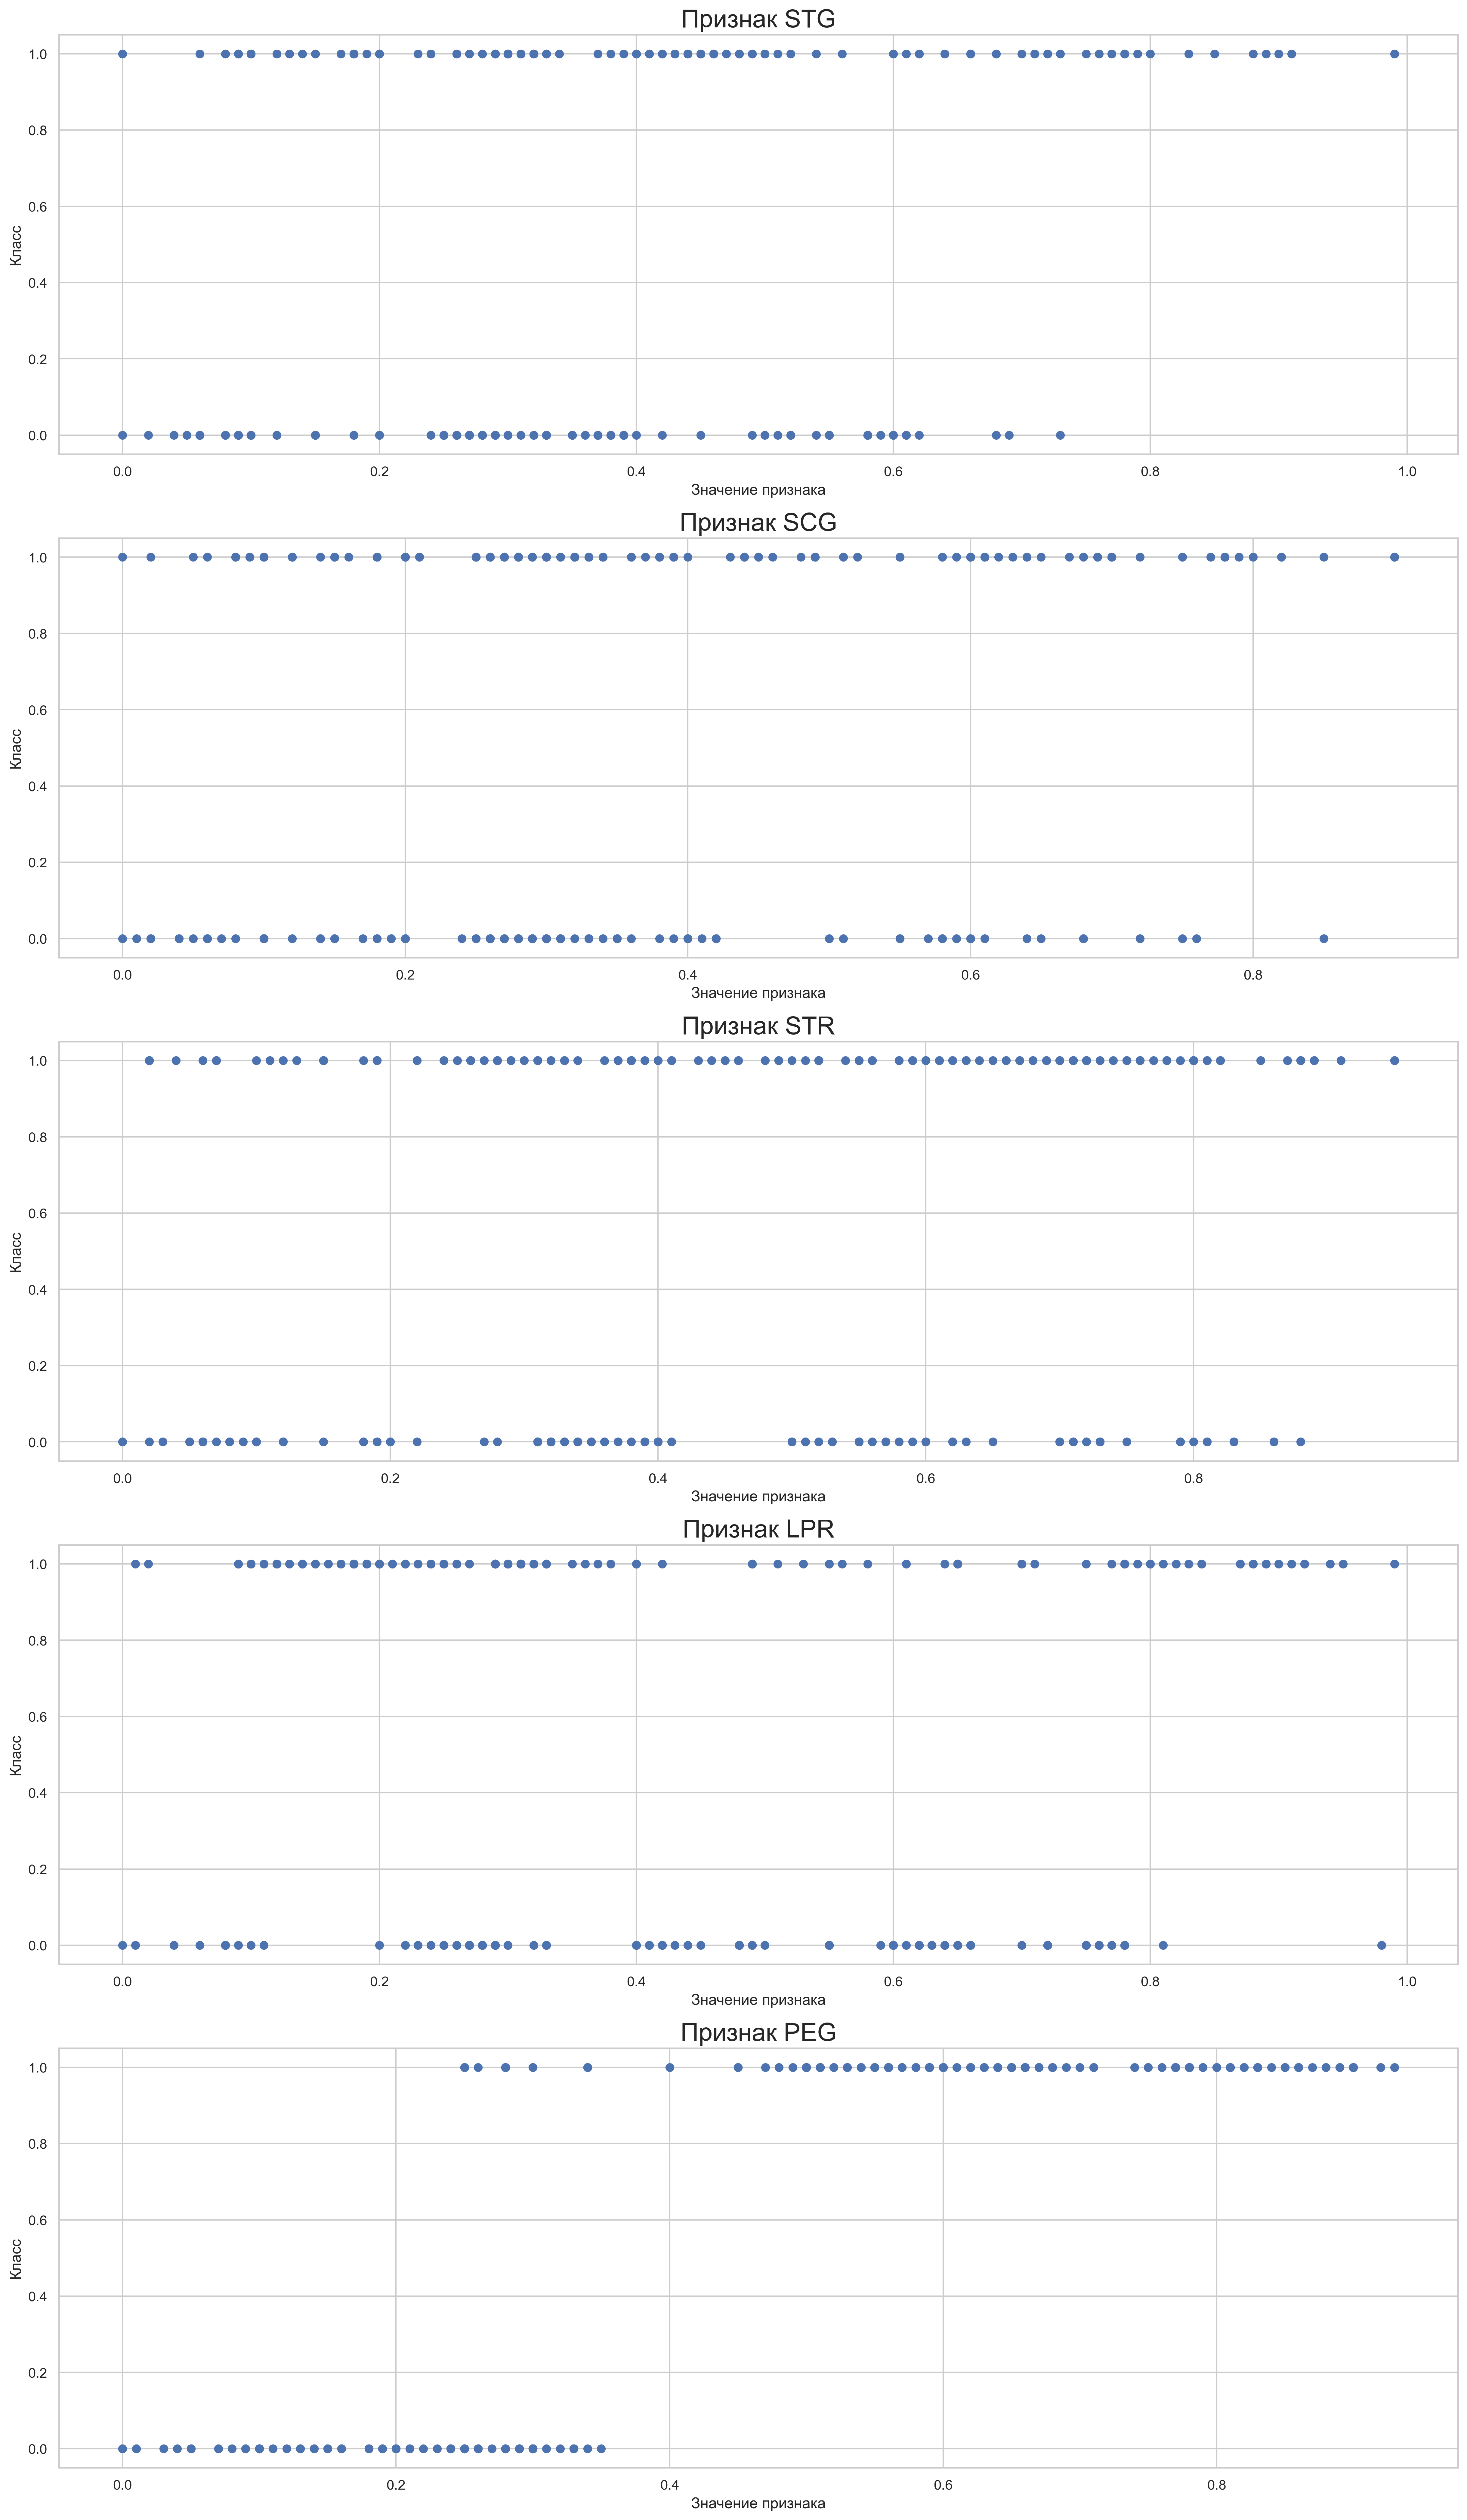

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 35), dpi=300)

for ax, feature in zip(axes, X.columns):
    ax.scatter(X[feature], y)

    ax.set_ylabel('Класс')
    ax.set_xlabel('Значение признака')
    ax.set_title(f'Признак {feature}', 
                 fontsize=20)

plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** очевидно что делить нужно по признаку PEG. Это согласуется с оценкой диаграмм рассеяния. Для хороших признаков кривая имеет вид "высокой горы" (Эверест), а диаграмма рассеяния имеет такой вид, что до какого-то значения признака класс один, а после этого значения класс другой. У плохих признаков кривая колеблется вверх-вниз совсем незначительно и не имеет "высоких горных пиков" (Уральские горы).

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [13]:
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
                  header=None)

In [14]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()

data = mushrooms.apply(lambda col: encoder.fit_transform(col), axis=0)

In [15]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [16]:
%autoreload 2
from hw5code import DecisionTree
from sklearn.metrics import accuracy_score


my_tree = DecisionTree(feature_types=["categorical" for _ in range(X_train.shape[1])]) # посадили дерево

my_tree.fit(X_train.values, y_train.values) # учим дерево

y_pred = my_tree.predict(X_test.values) # прогноз дерева

accuracy = accuracy_score(y_test.values, y_pred) # измеряем accuracy

print(f'Accuracy кастомного дерева: {accuracy}')

# дерево идеально работает на этих данных

Accuracy кастомного дерева: 1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [17]:
tic_tac_toe_endgame = pd.read_csv('tic-tac-toe-endgame.csv',
                   header=0)

encoder = LabelEncoder()

data = tic_tac_toe_endgame.apply(lambda col: encoder.fit_transform(col), axis=0)

data.head()

V1  V2  V3  V4  V5  V6  V7  V8  V9  V10
0   2   2   2   2   1   1   2   1   1    1
1   2   2   2   2   1   1   1   2   1    1
2   2   2   2   2   1   1   1   1   2    1
3   2   2   2   2   1   1   1   0   0    1
4   2   2   2   2   1   1   0   1   0    1

In [18]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

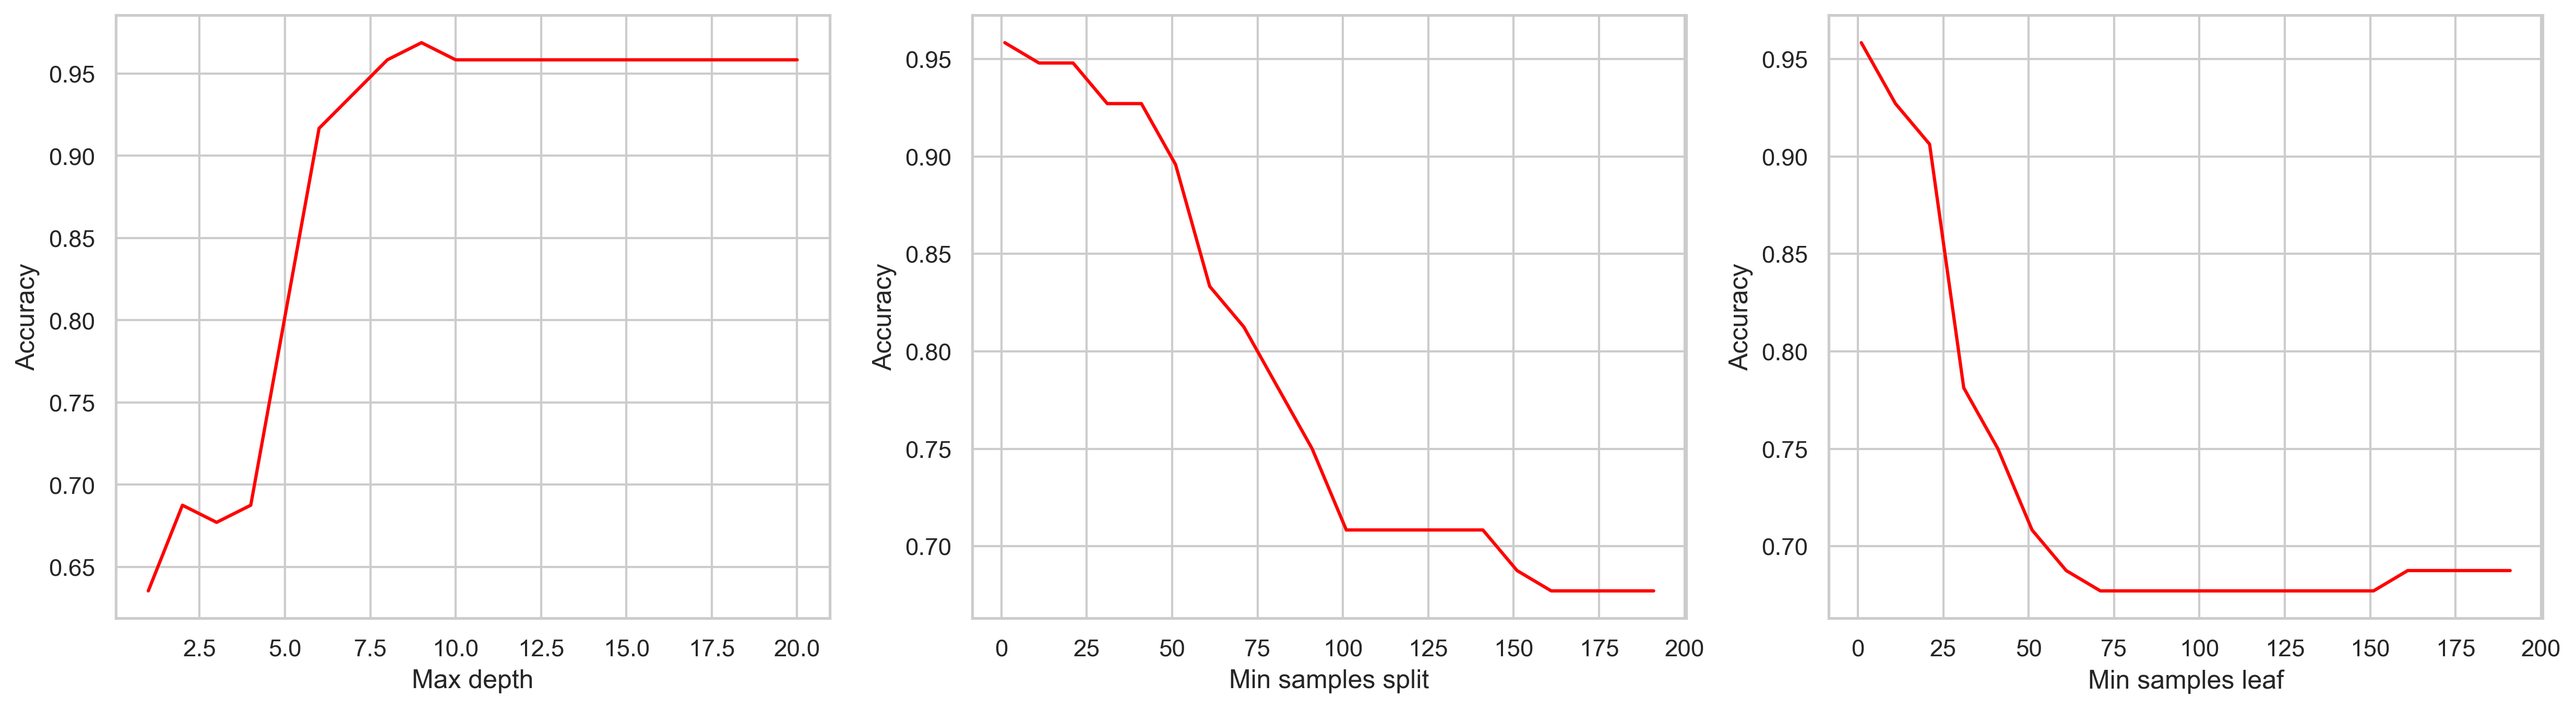

In [19]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=3, 
                       dpi=300, 
                       figsize=(20, 5))

params_dict = {
    'max_depth': list(range(20, 0, -1)),
    'min_samples_split': list(range(1, 201, 10)), 
    'min_samples_leaf': list(range(1, 201, 10))
}


for i, param in enumerate(params_dict):
    accuracys = []
    
    for param_value in params_dict[param]:
        if i == 0:
            clf = DecisionTree(feature_types=["categorical" for _ in range(X_train.shape[1])], 
                           max_depth=param_value
                          )
            ax[i].set_xlabel('Max depth')
        elif i == 1:
            clf = DecisionTree(feature_types=["categorical" for _ in range(X_train.shape[1])], 
                           min_samples_split=param_value
                          )
            ax[i].set_xlabel('Min samples split')
        elif i == 2:
            clf = DecisionTree(feature_types=["categorical" for _ in range(X_train.shape[1])], 
                           min_samples_leaf=param_value
                          )
            ax[i].set_xlabel('Min samples leaf')
        else:
            print('No params')

        clf.fit(X_train.values, y_train.values)
            
        y_pred = clf.predict(X_test.values)

        accuracy = accuracy_score(y_test.values, y_pred)

        accuracys.append(accuracy)

    ax[i].plot(params_dict[param], accuracys, color='red')
    ax[i].set_ylabel('Accuracy')


plt.show()

### __Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [20]:
cars = pd.read_csv('./car.data', header=None)
nursery = pd.read_csv('./nursery.data', header=None)

In [21]:
encoder = LabelEncoder()

mushrooms = mushrooms.apply(lambda col: encoder.fit_transform(col), axis=0)
tic_tac_toe_endgame = tic_tac_toe_endgame.apply(lambda col: encoder.fit_transform(col), axis=0)

cars.iloc[:, -1] = cars.iloc[:, -1].apply(lambda cls: 0 if cls in {'unacc', 'acc'} else 1)
cars = cars.apply(lambda col: encoder.fit_transform(col), axis=0)

nursery.iloc[:, -1] = nursery.iloc[:, -1].apply(lambda cls: 0 if cls in {'not_recom', 'recommend'} else 1)
nursery = nursery.apply(lambda col: encoder.fit_transform(col), axis=0)

In [22]:
datasets = {'mushrooms': {'X': mushrooms.iloc[:, 1:], 'y': mushrooms.iloc[:, 0]}, 
            'tic-tac-toe': {'X': tic_tac_toe_endgame.iloc[:, :-1], 'y': tic_tac_toe_endgame.iloc[:, -1]}, 
            'cars': {'X': cars.iloc[:, :-1], 'y': cars.iloc[:, -1]}, 
            'nursery': {'X': nursery.iloc[:, :-1], 'y': nursery.iloc[:, -1]}}

results = pd.DataFrame(index=list(datasets.keys()))

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder(drop='first', sparse_output=False)

for dataset in datasets:
    X, y = datasets[dataset]['X'].values, datasets[dataset]['y'].values

    est_all_real = DecisionTree(feature_types=["real" for _ in range(X.shape[1])])
    est_all_cat = DecisionTree(feature_types=["categorical" for _ in range(X.shape[1])])

    X_ohe = enc.fit_transform(X)
    est_all_real_ohe = DecisionTree(feature_types=["real" for _ in range(X_ohe.shape[1])])
    
    acc_all_real = cross_val_score(est_all_real, X, y, scoring=make_scorer(accuracy_score), cv=10)
    acc_all_cat = cross_val_score(est_all_real, X, y, scoring=make_scorer(accuracy_score), cv=10)
    acc_all_real_ohe = cross_val_score(est_all_real_ohe, X_ohe, y, scoring=make_scorer(accuracy_score), cv=10)
    acc_sklearn = cross_val_score(DecisionTreeClassifier(random_state=42), X, y, scoring=make_scorer(accuracy_score), cv=10)

    results.loc[dataset, 0] = np.mean(acc_all_real)
    results.loc[dataset, 1] = np.mean(acc_all_cat)
    results.loc[dataset, 2] = np.mean(acc_all_real_ohe)
    results.loc[dataset, 3] = np.mean(acc_sklearn)

res = results.rename(columns={0: 'all real', 1: 'all_cat', 2: 'all real ohe', 3: 'sklearn'})
res

all real   all_cat  all real ohe   sklearn
mushrooms    0.999261  0.999261      1.000000  0.960384
tic-tac-toe  0.467533  0.467533      0.556042  0.771678
cars         0.942647  0.942647      0.923498  0.942707
nursery      0.999691  0.999691      0.999846  0.999691

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** нет, где-то лучше ohe, а где-то склеарн. Мб так происходит потому что под копотом в sklearn делается прунинг, который как бы регуляризует дерево и оно меньше переобучается но при этом и становится проще, в отличие от нашей реализации. Хз чё там с признаками, в нашей реализации вроде случайности нет, а в склерновской имплементации зафиксировали рандом стейт. Возможно случайность появляется из-за разбиения на фолды при кросс валидации, но это как раз таки нужно для того, чтобы модель не переобучалась, поэтому улучшать тут нечего.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

![сомнительно но окэй](https://media.tenor.com/fK0HM80WMnIAAAAC/сомнительно-но-окей.gif)

[сплит контест](https://contest.yandex.ru/contest/56884/run-report/102442766/)  
[дерево контест](https://contest.yandex.ru/contest/56884/run-report/102442731/)  
ник aashabunya@edu.hse.ru  
[помогло реализовать сплит](https://stackoverflow.com/questions/1903462/how-can-i-zip-sort-parallel-numpy-arrays)